In [1]:
import glob,os
import numpy as np
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist,squareform
from scipy.stats import pearsonr
%matplotlib inline

In [2]:
#read file
data_folder = r'../Data/Bintu'
file_ = data_folder+os.sep+'IMR90_chr21-28-30Mb.csv'
lines = [ln[:-1].split(',') for ln in open(file_,'r')]

#keep only data enties and reorganize the data
keep = np.array(list(map(len, lines))) > 1
data = np.array([line for line,kp in zip(lines,keep) if kp][1:],dtype=float)
chromosomes = data[:,0]
nchr = len(np.unique(chromosomes))
zxys = data[:,2:].reshape([nchr,-1,3])
print(zxys.shape)

(4871, 65, 3)


In [3]:
distance_mats=np.array(list(map(squareform,map(pdist,zxys))))
avg_mat = np.nanmean(distance_mats, axis=0)
med_mat = np.nanmedian(distance_mats,axis=0)

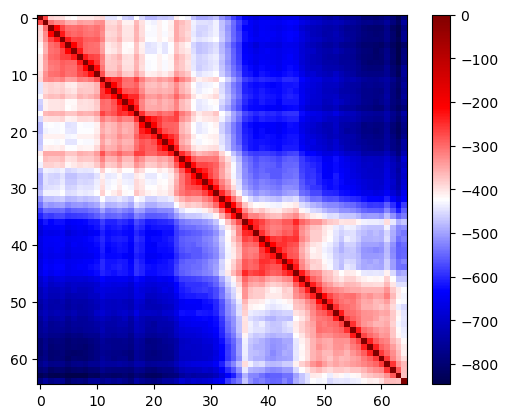

In [4]:
# Plot the median distance map
plt.figure()
plt.imshow(-med_mat,interpolation='nearest',cmap='seismic')
plt.colorbar()
plt.show()

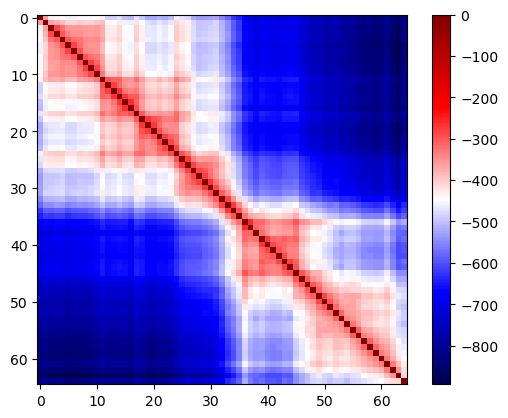

In [5]:
# Plot the average distance map
plt.figure()
plt.imshow(-avg_mat,interpolation='nearest',cmap='seismic')
plt.colorbar()
plt.show()

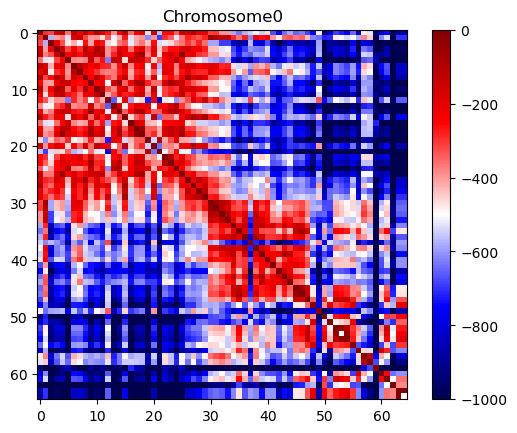

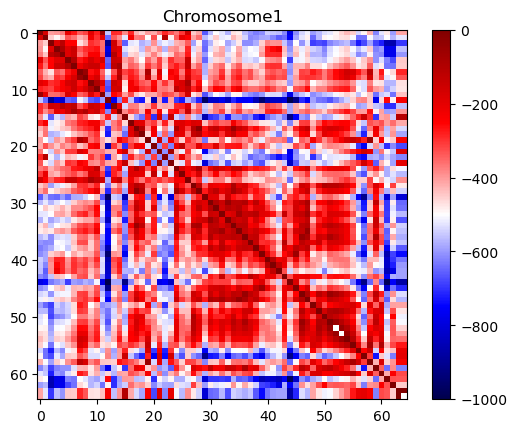

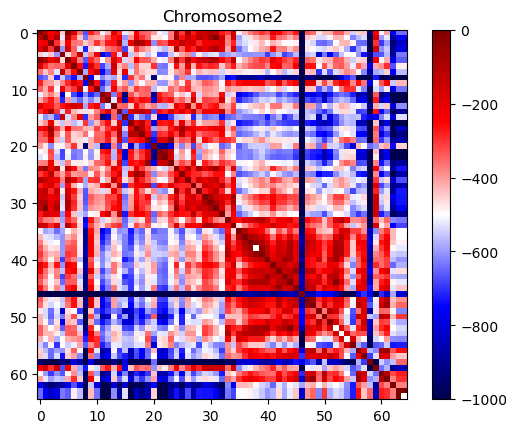

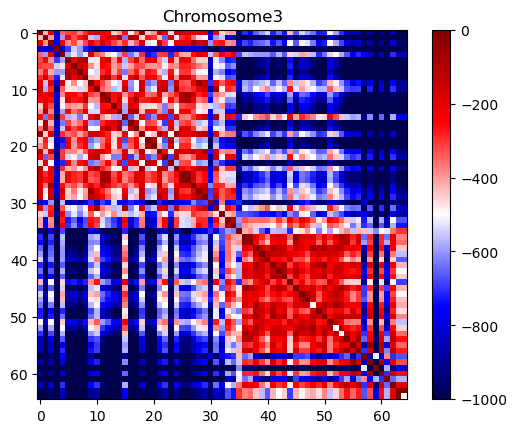

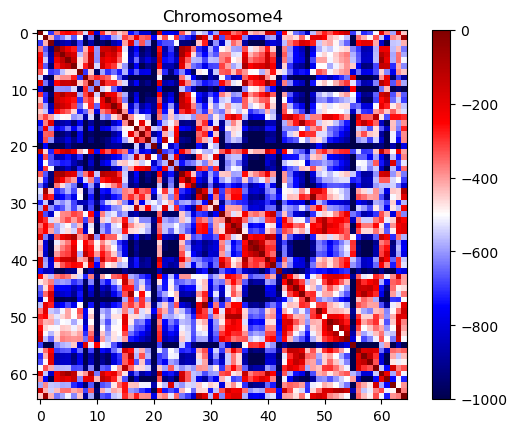

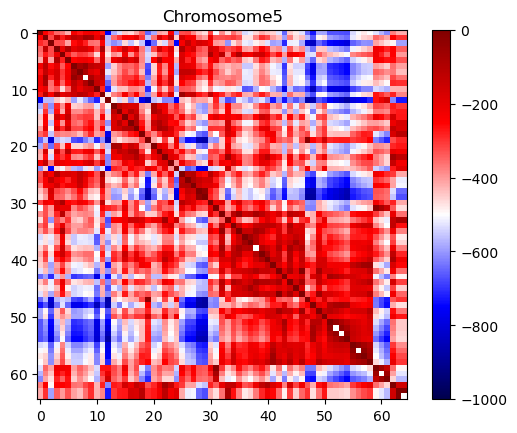

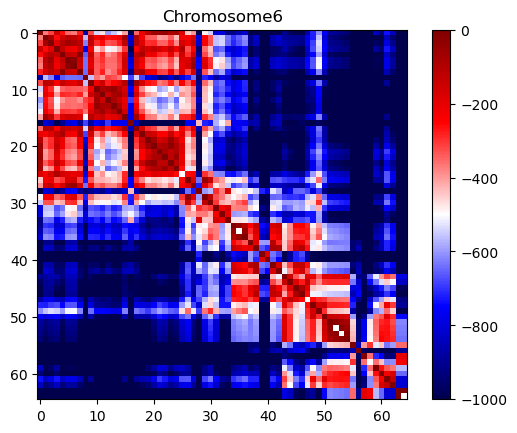

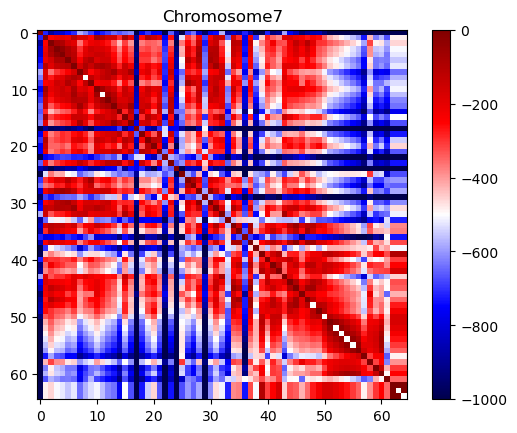

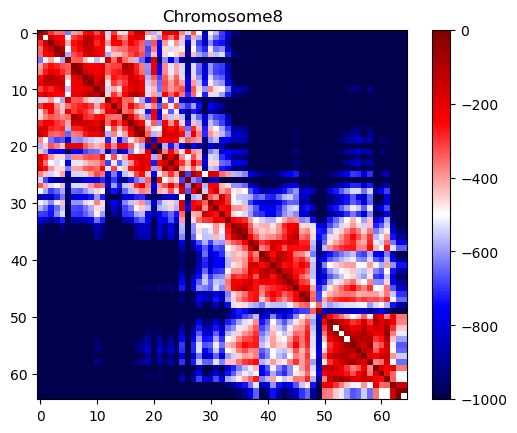

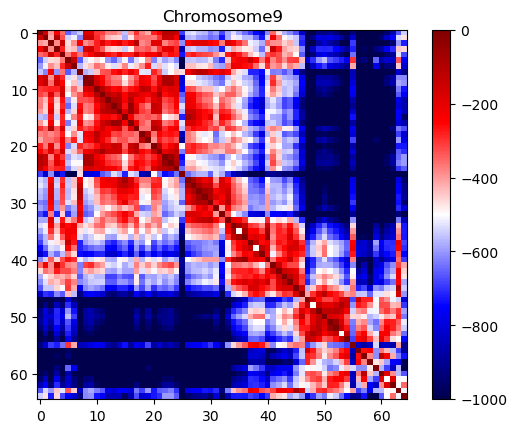

In [6]:
def interp1dnan(A):
    A_=np.array(A)
    missing = np.isnan(A)
    nonmissing = ~missing
    xp = np.where(nonmissing)[0]
    fp = A[nonmissing]
    x  = np.where(missing)[0]
    A_[missing] = np.interp(x, xp, fp)
    return A_

def plot_map(zxy,interpolate=True):
    """
    We can interpolate across positions we do not have data (too dim to reliably fit).
    We mark those positions as white on the diagonal.
    """
    zxy_ = np.array(zxy)
    if interpolate:
        zxy_ = np.array([interp1dnan(col) for col in zxy.T]).T
        bad = np.where(np.isnan(zxy[:,0]))[0]
    mat_ = squareform(pdist(zxy_))
    mat_[bad,bad]=np.nan
    plt.imshow(-mat_,interpolation='nearest',cmap='seismic',vmin=-1000,vmax=0)

for i in range(10):
    plt.figure()
    plt.title('Chromosome'+str(i))
    
    plot_map(zxys[i])
    
    plt.colorbar()
    plt.show()

In [7]:
# Find the most similar cell to the average distance matrix using Pearson correlation
# Handle NaN values using interpolation similar to the plot_map function

def find_most_similar_cell_to_average(zxys, avg_mat):
    """
    Find the cell most similar to the average distance matrix using Pearson correlation.
    Handle NaN values by interpolating missing positions.
    """
    n_cells = len(zxys)
    correlations = []
    
    # Get the average distance matrix as a flattened vector (upper triangle only)
    n_loci = avg_mat.shape[0]
    tri_mask = np.triu_indices(n_loci, k=1)  # Upper triangle indices, excluding diagonal
    avg_vec = avg_mat[tri_mask]
    
    # Remove NaN values from average vector for correlation calculation
    avg_valid_mask = ~np.isnan(avg_vec)
    avg_vec_clean = avg_vec[avg_valid_mask]
    
    print(f"Analyzing {n_cells} cells...")
    print(f"Distance matrix size: {n_loci} x {n_loci}")
    print(f"Valid entries in average matrix: {np.sum(avg_valid_mask)} out of {len(avg_vec)}")
    
    for i in range(n_cells):
        try:
            # Get current cell's 3D coordinates
            zxy = zxys[i]
            
            # Apply interpolation to handle NaN values, similar to plot_map function
            zxy_filled = np.array(zxy)
            nan_positions = np.isnan(zxy[:, 0])  # Check first coordinate for NaN
            
            if np.any(nan_positions):
                # Interpolate each coordinate separately
                for coord_idx in range(3):  # x, y, z coordinates
                    zxy_filled[:, coord_idx] = interp1dnan(zxy[:, coord_idx])
            
            # Calculate distance matrix for this cell
            cell_dist_mat = squareform(pdist(zxy_filled))
            
            # Get upper triangle vector
            cell_vec = cell_dist_mat[tri_mask]
            
            # Use only positions that are valid in both vectors
            cell_valid_mask = ~np.isnan(cell_vec)
            combined_valid_mask = avg_valid_mask & cell_valid_mask
            
            if np.sum(combined_valid_mask) < 10:  # Need enough valid points for correlation
                correlations.append(np.nan)
                continue
            
            # Calculate Pearson correlation using only valid positions
            avg_vec_for_corr = avg_vec[combined_valid_mask]
            cell_vec_for_corr = cell_vec[combined_valid_mask]
            
            if len(avg_vec_for_corr) > 1 and np.std(avg_vec_for_corr) > 0 and np.std(cell_vec_for_corr) > 0:
                corr_val, _ = pearsonr(avg_vec_for_corr, cell_vec_for_corr)
                correlations.append(corr_val)
            else:
                correlations.append(np.nan)
                
        except Exception as e:
            print(f"Error processing cell {i}: {e}")
            correlations.append(np.nan)
        
        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1} cells...")
    
    correlations = np.array(correlations)
    
    # Find the cell with highest correlation (most similar)
    valid_correlations = correlations[~np.isnan(correlations)]
    valid_indices = np.where(~np.isnan(correlations))[0]
    
    if len(valid_correlations) == 0:
        print("No valid correlations found!")
        return None, None, correlations
    
    most_similar_idx = valid_indices[np.argmax(valid_correlations)]
    max_correlation = np.max(valid_correlations)
    
    print(f"\nResults:")
    print(f"Total cells analyzed: {n_cells}")
    print(f"Cells with valid correlations: {len(valid_correlations)}")
    print(f"Most similar cell index: {most_similar_idx}")
    print(f"Highest correlation: {max_correlation:.4f}")
    
    return most_similar_idx, max_correlation, correlations

# Execute the analysis
most_similar_cell_idx, best_correlation, all_correlations = find_most_similar_cell_to_average(zxys, avg_mat)

Analyzing 4871 cells...
Distance matrix size: 65 x 65
Valid entries in average matrix: 2080 out of 2080
Processed 500 cells...
Processed 1000 cells...
Processed 1500 cells...
Processed 2000 cells...
Processed 2500 cells...
Processed 1500 cells...
Processed 2000 cells...
Processed 2500 cells...
Processed 3000 cells...
Processed 3500 cells...
Processed 4000 cells...
Processed 3000 cells...
Processed 3500 cells...
Processed 4000 cells...
Processed 4500 cells...

Results:
Total cells analyzed: 4871
Cells with valid correlations: 4870
Most similar cell index: 705
Highest correlation: 0.9254
Processed 4500 cells...

Results:
Total cells analyzed: 4871
Cells with valid correlations: 4870
Most similar cell index: 705
Highest correlation: 0.9254


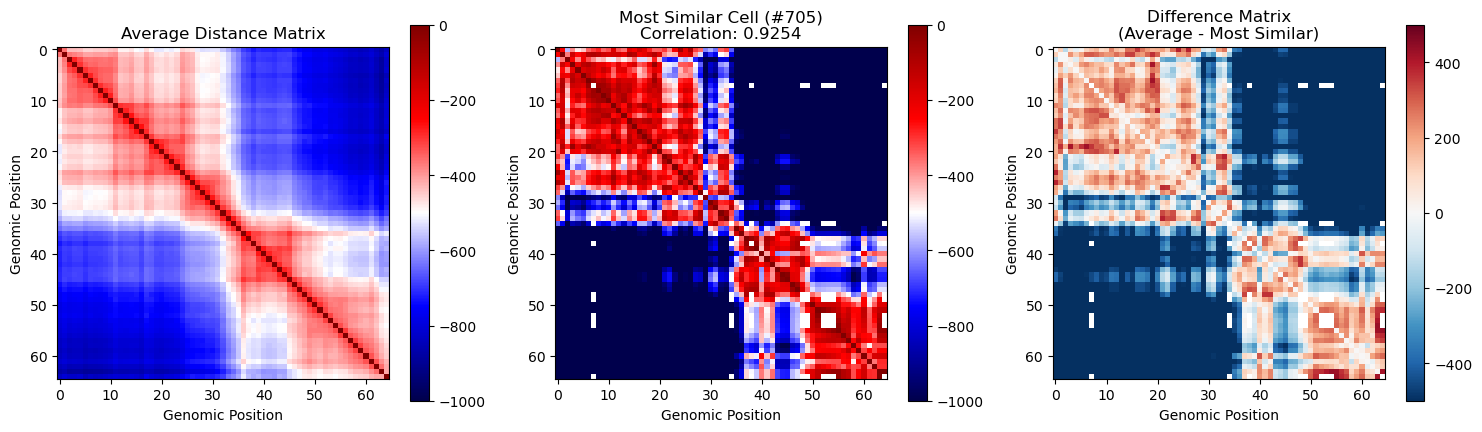

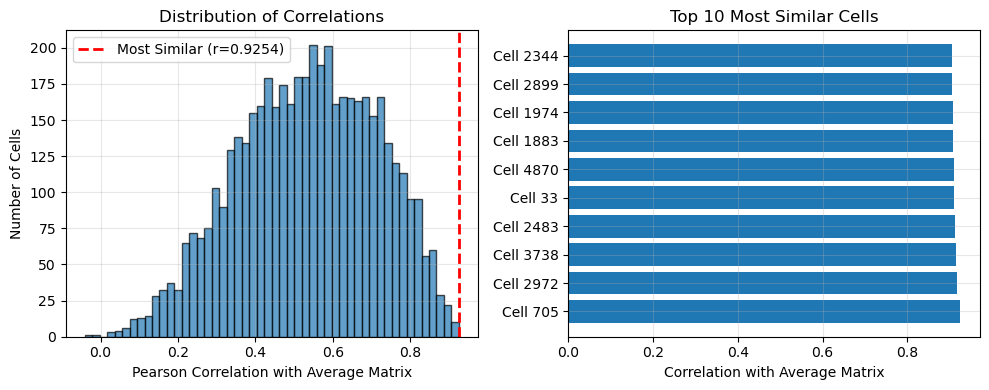


Top 10 most similar cells:
 1. Cell  705: correlation = 0.9254
 2. Cell 2972: correlation = 0.9170
 3. Cell 3738: correlation = 0.9147
 4. Cell 2483: correlation = 0.9127
 5. Cell   33: correlation = 0.9111
 6. Cell 4870: correlation = 0.9106
 7. Cell 1883: correlation = 0.9085
 8. Cell 1974: correlation = 0.9077
 9. Cell 2899: correlation = 0.9065
10. Cell 2344: correlation = 0.9064


In [8]:
# Visualize the results
if most_similar_cell_idx is not None:
    # Plot comparison between average matrix and most similar cell
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Average distance matrix
    axes[0].imshow(-avg_mat, interpolation='nearest', cmap='seismic', vmin=-1000, vmax=0)
    axes[0].set_title('Average Distance Matrix')
    axes[0].set_xlabel('Genomic Position')
    axes[0].set_ylabel('Genomic Position')
    
    # Plot 2: Most similar cell's distance matrix
    most_similar_zxy = zxys[most_similar_cell_idx]
    # Apply interpolation to handle NaN values
    most_similar_zxy_filled = np.array(most_similar_zxy)
    nan_positions = np.isnan(most_similar_zxy[:, 0])
    if np.any(nan_positions):
        for coord_idx in range(3):
            most_similar_zxy_filled[:, coord_idx] = interp1dnan(most_similar_zxy[:, coord_idx])
    
    most_similar_dist_mat = squareform(pdist(most_similar_zxy_filled))
    # Mark original NaN positions
    if np.any(nan_positions):
        bad_positions = np.where(nan_positions)[0]
        most_similar_dist_mat[bad_positions[:, None], bad_positions] = np.nan
    
    im2 = axes[1].imshow(-most_similar_dist_mat, interpolation='nearest', cmap='seismic', vmin=-1000, vmax=0)
    axes[1].set_title(f'Most Similar Cell (#{most_similar_cell_idx})\nCorrelation: {best_correlation:.4f}')
    axes[1].set_xlabel('Genomic Position')
    axes[1].set_ylabel('Genomic Position')
    
    # Plot 3: Difference matrix
    diff_mat = avg_mat - most_similar_dist_mat
    im3 = axes[2].imshow(diff_mat, interpolation='nearest', cmap='RdBu_r', vmin=-500, vmax=500)
    axes[2].set_title('Difference Matrix\n(Average - Most Similar)')
    axes[2].set_xlabel('Genomic Position')
    axes[2].set_ylabel('Genomic Position')
    
    # Add colorbars
    plt.colorbar(im2, ax=axes[0], shrink=0.8)
    plt.colorbar(im2, ax=axes[1], shrink=0.8)
    plt.colorbar(im3, ax=axes[2], shrink=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Show distribution of correlations
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    valid_corrs = all_correlations[~np.isnan(all_correlations)]
    plt.hist(valid_corrs, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(best_correlation, color='red', linestyle='--', linewidth=2, 
                label=f'Most Similar (r={best_correlation:.4f})')
    plt.xlabel('Pearson Correlation with Average Matrix')
    plt.ylabel('Number of Cells')
    plt.title('Distribution of Correlations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Show top 10 most similar cells
    valid_indices = np.where(~np.isnan(all_correlations))[0]
    valid_correlations = all_correlations[valid_indices]
    sorted_indices = valid_indices[np.argsort(valid_correlations)[::-1]]
    top_10_indices = sorted_indices[:10]
    top_10_corrs = all_correlations[top_10_indices]
    
    plt.barh(range(len(top_10_indices)), top_10_corrs)
    plt.yticks(range(len(top_10_indices)), [f'Cell {idx}' for idx in top_10_indices])
    plt.xlabel('Correlation with Average Matrix')
    plt.title('Top 10 Most Similar Cells')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 10 most similar cells:")
    for i, (idx, corr) in enumerate(zip(top_10_indices, top_10_corrs)):
        print(f"{i+1:2d}. Cell {idx:4d}: correlation = {corr:.4f}")
        
else:
    print("No valid correlations found. Cannot identify most similar cell.")